In [7]:
# Import necessary libraries and classes
import os
from data_prep import HiKDataset
from torch.utils.data import DataLoader
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch

# Load the dataset
dataset = HiKDataset(
    dataset="C",  # Specify the dataset you want to use
    data_location="data",
    sample_length=30,
    step_size=30,
    downsample_rate=6
)

# Extract poses and labels
poses = []
labels = []
for data in dataset:
    poses.append(data["poses"].numpy())
    labels.append(data["activity_label"].numpy())

poses = np.array(poses)
labels = np.array(labels)



100%|██████████| 319/319 [00:06<00:00, 49.60it/s]


Poses shape: (30249, 5, 3, 29)
Labels shape: (30249, 82)
Labels flattened shape: (2480418,)
Labels encoded shape: (2480418,)


AssertionError: Poses and labels must be of the same length

In [9]:
# Convert one-hot encoded labels to single class labels
labels_single_class = np.argmax(labels, axis=1)

# Print shape after conversion
print(f"Labels single class shape: {labels_single_class.shape}")

# Encode labels to ensure they are in a supported format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_single_class)

# Print shape after encoding
print(f"Labels encoded shape: {labels_encoded.shape}")

# Ensure that the labels and poses are correctly aligned
assert len(poses) == len(labels_encoded), "Poses and labels must be of the same length"

# Reshape poses to 2D for oversampling
n_samples, n_frames, n_xyz, n_joints = poses.shape
poses_reshaped = poses.reshape(n_samples, -1)

# Perform oversampling to balance the classes
ros = RandomOverSampler()
poses_resampled, labels_resampled = ros.fit_resample(poses_reshaped, labels_encoded)

# Reshape poses back to original shape
poses_resampled = poses_resampled.reshape(-1, n_frames, n_xyz, n_joints)

# Create a balanced dataset
class BalancedHiKDataset(HiKDataset):
    def __init__(self, poses, labels):
        self.poses = poses
        self.labels = labels

    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        return {
            "poses": torch.tensor(self.poses[idx], dtype=torch.float32),
            "activity_label": torch.tensor(self.labels[idx], dtype=torch.float32)
        }

balanced_dataset = BalancedHiKDataset(poses_resampled, labels_resampled)

# Create a DataLoader for the balanced dataset
balanced_dataloader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

# Now you can use balanced_dataloader for training your model

Labels single class shape: (30249,)
Labels encoded shape: (30249,)


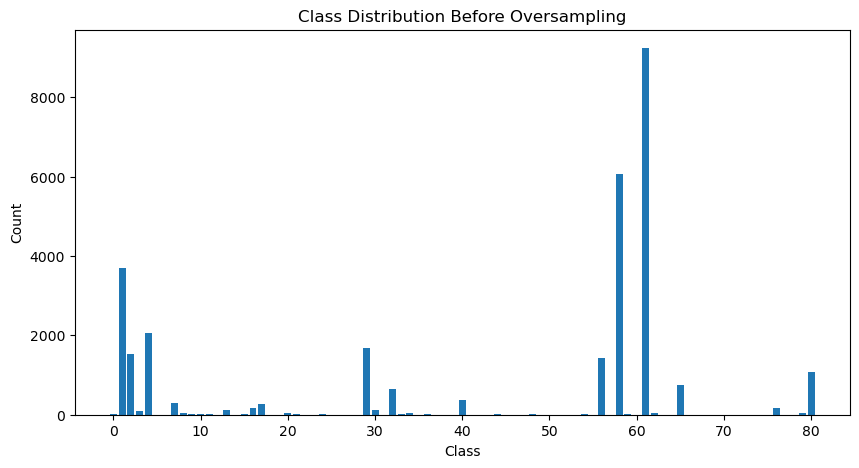

In [11]:
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

# Plot class distribution before oversampling
plot_class_distribution(labels_single_class, 'Class Distribution Before Oversampling')

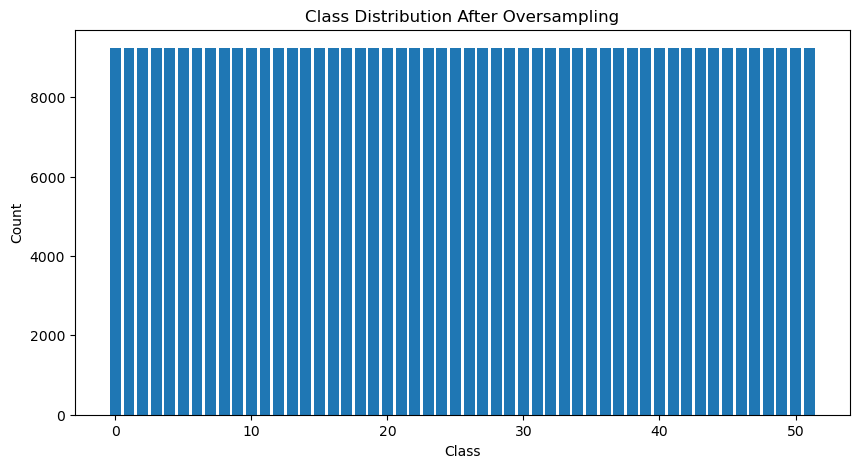

In [12]:
# Plot class distribution after oversampling
plot_class_distribution(labels_resampled, 'Class Distribution After Oversampling')